In [2]:
# -*- coding: utf-8 -*-
import sys
import random
import re
import copy
import math
import numpy as np
import operator
import datetime
import os
import json
import itertools 
import pandas as pd
import matplotlib.pyplot as plt

class Graph:

    def __init__(self, f):        
        self.graph,self.nodes = self.read_graph(open(f))        
        self.in_nodes = self.get_in_nodes()
        self.out_nodes = self.graph

    def get_in_nodes(self):
        in_nodes = {}
        for node in self.nodes:
            in_nodes[node] = []
        
        for source, targets in self.graph.items():
            for node in targets:
                if str(source) not in in_nodes[str(node)]:
                    in_nodes[str(node)].append(str(source))
        return in_nodes


    def read_graph(self,f):
        graph = {}
        nodes = []
        for line in f.readlines():
            source, target = self.parse_format(line)
            if source not in graph:
                graph[source] = [target]
            else:
                graph[source].append(target)

            if source not in nodes:
                nodes.append(source)
            if target not in nodes:
                nodes.append(target)
        return graph,nodes  
    
    def parse_format(self,line):
        source, target = line.split(',')
#         match = re.search('([0-9]+)', target)
        match = re.search('([0-9A-Za-z]+)', target) # 擴充通用
        if match:
            target = match.groups()[0]
        return source, target   

In [3]:
class TCGraph:
    def __init__(self, f):        
        print('transform dataset...')
        TDB_List = self.read_transaction(f)
        f = f.replace('csv','txt')
        print('making graph...')
        self.make_graph(copy.deepcopy(TDB_List),f) 
        self.graph,self.nodes = self.read_graph(open(f))       
        self.in_nodes = self.get_in_nodes()
        self.out_nodes = self.graph
        

    def get_in_nodes(self):
        in_nodes = {}
        for node in self.nodes:
            in_nodes[node] = []
        
        for source, targets in self.graph.items():
            for node in targets:
                if str(source) not in in_nodes[str(node)]:
                    in_nodes[str(node)].append(str(source))
        return in_nodes


    def read_graph(self,f):
        graph = {}
        nodes = []
        for line in f.readlines():
            source, target = self.parse_format(line)
            if source not in graph:
                graph[source] = [target]
            else:
                graph[source].append(target)

            if source not in nodes:
                nodes.append(source)
            if target not in nodes:
                nodes.append(target)
        return graph,nodes
    
    def read_transaction(self,f):
        bakery_data = pd.read_csv(f, encoding='utf-8')
        bakery_data = bakery_data.drop(['Date', 'Time'], axis=1)
        bakery_data = bakery_data[~bakery_data['Item'].str.contains('NONE')]
        wk = self.wordKey(bakery_data['Item'].unique())

        tdl = []
        for i in range(1, bakery_data.Transaction.count() + 1):
            tdf = bakery_data[bakery_data.Transaction == i]
            l = set()
            for j in range(0, tdf.Transaction.count()):
                l.add(wk[tdf.Item.iloc[j]])
            if len(l) > 0:
                tdl.append(list(l))
            else:
                tdl.append(None)

        col = ['items']
        TDB = pd.DataFrame({"items": tdl}, columns=col)
        TDB = TDB.dropna()   
        return TDB['items'].tolist()

    def make_graph(self,tdb,wfn):
        edge_list = []
        wk = {self.wk[k]:k for k in self.wk} 
        for t in tdb:
            for a, b in itertools.product(t, t):
                if a != b and ((b,a) not in edge_list) and ((a,b) not in edge_list):
#                     edge_list.append((wk[int(a)],wk[int(b)])) # 文字版
                    edge_list.append((a,b)) # 數字版

        print('edge finished')
        with open(wfn,'w') as f:
            for e in edge_list: 
                line = str(e).replace('(','').replace(')','').replace("'",'')         
                f.write(line)
                f.write('\n') 

    def parse_format(self,line):
        source, target = line.split(',')
#         match = re.search('([0-9]+)', target)
        match = re.search('([0-9]+)', target) # 擴充通用
        if match:
            target = match.groups()[0]
        return source, target
    
    def wordKey(self,items):
        # 轉化字典
        node_list = pd.Series(items).astype('category').cat.codes.values+1
        word_key = {}
        for i in range(0,len(node_list)):
            word_key[items[i]] = node_list[i]
        print('-------------word_key--------------')
        self.wk = word_key
#         print(word_key)           
        return word_key

In [4]:
class Hits:    
    def __init__(self,graph, iteration=5, min_delta=0.0001):
        self.auth = dict.fromkeys(graph.nodes, 1.0)
        self.hubs = dict.fromkeys(graph.nodes, 1.0)
        self.iteration = iteration
        self.min_delta = min_delta
        self.graph = graph
    
    def do(self):
        auth = self.auth
        hubs = self.hubs
        graph = self.graph
        for i in range(int(self.iteration)):
            
            old_auth = auth.copy()
            for node in graph.nodes:
                auth[node] = self.sum_hubs(graph, node, hubs)
            auth = self.normalization(auth)

            old_hub = hubs.copy()
            for node in graph.nodes:       
                hubs[node] = self.sum_authorities(graph, node, auth)
            hubs = self.normalization(hubs)
            delta = sum((abs(old_hub[k] - hubs[k]) for k in hubs)) + sum((abs(old_auth[k] - auth[k]) for k in auth))
            if delta <= self.min_delta:
                mean_auth = sum(auth.values())/len(auth.values())
                mean_hub = sum(hubs.values())/len(hubs.values())
        #         print("Authority : {}".format(auth))
        #         print("Hub : {} ".format(hubs))
                print("Mean Authority : {}".format(mean_auth))
                print("Mean Hub : {}".format(mean_hub))
                return (auth, hubs,mean_auth,mean_hub)

    def sum_hubs(self,graph, node, hubs):
        s_hubs = 0.0
        if node not in graph.in_nodes:
            return s_hubs

        for in_node in graph.in_nodes[node]:
            s_hubs += hubs[in_node]
        return s_hubs

    def sum_authorities(self,graph, node, authorities):
        s_authorities = 0.0

        if node not in graph.out_nodes:
            return s_authorities

        for out_node in graph.out_nodes[node]:
            s_authorities += authorities[str(out_node)]
        return s_authorities

    def normalization(self,dic):
        norm = sum((dic[p] for p in dic))
        return {k: v / norm for (k, v) in dic.items()}
    
    def write_result(self,output_file):
        output_file = 'result/' + os.path.basename(output_file)
        output_file = output_file.split('.') [0]  
        auth_file = output_file + '_auth.json'                
        with open(auth_file, 'w') as auth_file:
            json.dump(self.auth, auth_file, indent=4)            
        hub_file = output_file + '_hubs.json'                
        with open(hub_file, 'w') as hub_file:
            json.dump(self.hubs, hub_file, indent=4)
            

In [5]:
class PageRank:    
    def __init__(self,graph, iteration=20, damping_factor=0.85):        
        self.iteration = iteration
        self.damping_factor = damping_factor
        self.ranks = None
        self.graph = graph
    
    def do(self):
        iteration = self.iteration
        damping_factor = self.damping_factor
        graph = self.graph
        num_nodes = len(graph.nodes)
        ranks = dict.fromkeys(graph.nodes, 1.0/num_nodes) #初始化各node的rank值
        min_value = 1 - damping_factor # (1-d)
        for i in range(int(iteration)):
            for node in graph.nodes:
                if node not in graph.out_nodes: # no parent
                    ranks[node] = 0 # 給予沒有被連接到的node=> zero rank
                    continue
                rank = min_value
                for in_node in graph.in_nodes[node]: # 計算所有鏈結至V_j的in_node
                    rank += damping_factor * ranks[in_node] / len(graph.out_nodes[in_node])
                ranks[node] = rank # PR(V_j)
                
        self.ranks = ranks 
#         print("Ranks : {}".format(ranks))
        return ranks
    
    def write_result(self,output_file):
        output_file = 'result/' + os.path.basename(output_file)
        output_file = output_file.split('.') [0]  
        rank_file = output_file + '_rank.json'                
        with open(rank_file, 'w') as rank_file:
            json.dump(self.ranks, rank_file, indent=4)            
        

In [6]:
class SimRank:
    def __init__(self,graph, C=0.9, iteration=20):
        self.iteration = iteration
        self.C = C     
        if hasattr(graph, 'wk'):
            wk = graph.wk
            self.sim = np.identity(len(wk.values()))
            self.old_sim = np.zeros(len(wk.values()))   
            self.wk = { wk[k]:k for k in wk}        
        else:
            self.sim = np.identity(len(graph.nodes))
            self.old_sim = np.zeros(len(graph.nodes))
            
        self.graph = graph    
        
    def do(self):
        sim = self.sim
        old_sim = self.old_sim
        graph = self.graph
        for i in range(int(self.iteration)):
            old_sim = np.copy(sim)
            # 利用product笛卡爾積求多個(a,b)組合物件
            for a, b in itertools.product(graph.nodes, graph.nodes):
               #  print("a:{} , b:{} a is b :{} ".format(a,b,a == b))
                if a == b or len(graph.in_nodes[a]) == 0 or len(graph.in_nodes[b]) == 0:
                    continue
                s_ab = 0 # calculate S(I_i(a),I_j(b))
                for na in graph.in_nodes[a]:
                    for nb in graph.in_nodes[b]:
                        s_ab += old_sim[int(na)-1][int(nb)-1]
                sim[int(a)-1][int(b)-1] = self.C / (len(graph.in_nodes[a]) * len(graph.in_nodes[b]))*s_ab
        print('pair-wise similarity of nodes...' )
        size = len(old_sim[0])
        
        if hasattr(graph, 'wk'):
            recover_col = [self.wk[i] for i in list(range(1,size+1))]
            self.sim = pd.DataFrame(sim,columns=recover_col,index=recover_col)    
        else:
            self.sim = pd.DataFrame(sim,columns=list(range(1,size+1)),index=list(range(1,size+1)))     
        return self.sim
    
    def write_result(self,output_file):
        output_file = 'result/' + os.path.basename(output_file)
        output_file = output_file.split('.') [0]  
        self.sim.to_csv(output_file + '_sim_rank.csv')

In [7]:
def linkTest(fn,itr):
    fmt = fn.split('.')[1]
    if fmt != 'csv':
        graph = Graph(fn)
    else:
        graph = TCGraph(fn)
        wk = {graph.wk[k]:k for k in graph.wk} 
#         print(wk)
        
    s_hits = datetime.datetime.now()
    hits = Hits(graph,iteration=itr, min_delta=0.0001)
    auth, hubs,_,_ = hits.do()    
    e_hits = datetime.datetime.now()
    print("Do hits during time : {} ms".format((e_hits - s_hits).microseconds))
    hits.write_result(fn) 

    
    # 大到小sort
    sorted_auth = sorted(auth.items(), key=operator.itemgetter(1),reverse=True)
    sorted_hubs = sorted(hubs.items(), key=operator.itemgetter(1),reverse=True)
    if hasattr(graph, 'wk'):  
        print('Top 10 sorted_auth : {}'.format([wk[int(a[0])] for a in sorted_auth[:5]]))
        print('Top 10 sorted_hubs : {}'.format([wk[int(a[0])] for a in sorted_hubs[:5]]))        
    else:
        print('Top 10 sorted_auth : {}'.format([a[0] for a in sorted_auth[:5]]))
        print('Top 10 sorted_hubs : {}'.format([a[0] for a in sorted_hubs[:5]]))        

    # 小到大sort    
    sorted_auth = sorted(auth.items(), key=operator.itemgetter(1))
    sorted_hubs = sorted(hubs.items(), key=operator.itemgetter(1))    
    if hasattr(graph, 'wk'):  
        print('Reciprocal 10 sorted_auth : {}'.format([wk[int(a[0])] for a in sorted_auth[:5]]))
        print('Reciprocal 10 sorted_hubs : {}'.format([wk[int(a[0])] for a in sorted_hubs[:5]]))
    else:        
        print('Reciprocal 10 sorted_auth : {}'.format([a[0] for a in sorted_auth[:5]]))
        print('Reciprocal 10 sorted_hubs : {}'.format([a[0] for a in sorted_hubs[:5]]))

    # page_rank
    # 6 graphs in project3dataset
    s_rank = datetime.datetime.now()
    page_rank = PageRank(graph, iteration=itr, damping_factor=0.85)
    ranks = page_rank.do()
    e_rank = datetime.datetime.now()
    print("Do page_rank during time : {} ms".format((e_rank - s_rank).microseconds))
    page_rank.write_result(fn) 
    
    # 大到小sort
    sorted_rank = sorted(ranks.items(), key=operator.itemgetter(1),reverse=True)
    if hasattr(graph, 'wk'):  
        print('sorted_rank : {}'.format([wk[int(a[0])] for a in sorted_rank[:5]]))
    else:
        print('sorted_rank : {}'.format([a[0] for a in sorted_rank[:5]]))
    
    # 小到大sort
    sorted_rank = sorted(ranks.items(), key=operator.itemgetter(1))
    if hasattr(graph, 'wk'):  
        print('Reciprocal sorted_rank : {}'.format([wk[int(a[0])] for a in sorted_rank[:5]]))
    else:
        print('Reciprocal sorted_rank : {}'.format([a[0] for a in sorted_rank[:5]]))    

    # sim_rank
    # first 5 graphs of project3dataset.
    s_sim = datetime.datetime.now()
    simRank = SimRank(graph, C=0.9, iteration=itr)
    sim = simRank.do()   
    e_sim = datetime.datetime.now()
    print("Do sim_rank during time : {} ms".format((e_sim - s_sim).microseconds))
    simRank.write_result(fn) 
    
#     print('---Similarity Orignal matrix---')
#     print(np.matrix(sim))
    
    matrix = np.matrix(sim.replace(1, 0))
    max_score = matrix.max()
    print("Node Max Similarity value (Without self) : {} ".format(max_score))  
    

    inverse_unique_set = []
    for i in range(0,len(matrix)):
        for j in range(0,len(matrix)):
            if (sim.iloc[i,j] == max_score and (max_score!=0) and (i+1,j+1) not in inverse_unique_set):
                if hasattr(graph, 'wk'):
                    print("Node:{} & Node:{} Similarity high : {}".format(wk[(i+1)],wk[(j+1)],max_score))
                else:
                    print("Node:{} & Node:{} Similarity high : {}".format(i+1,j+1,max_score))
                inverse_unique_set.append((j+1,i+1))                    
                break
                
#     print(sim.loc[max_score])
#     print(sim.index.get_loc(matrix.max()))

In [8]:
if __name__=='__main__':

    for i in range(1,5):
        fn = 'hw3dataset/graph_{}.txt'.format(i)
        linkTest(fn,itr=20)
        print('\n' +'---------------' + fn + 'Over'+'---------------'+ '\n')
        
    for i in range(5,7):
        fn = 'hw3dataset/graph_{}.txt'.format(i)
        linkTest(fn,itr=50)
        print('\n' +'---------------' + fn + 'Over'+'---------------'+ '\n')        
    
    fn = 'hw3dataset/BreadBasket_DMS.csv'
    linkTest(fn,itr=20)
    print('\n' +'---------------' + fn + 'Over'+'---------------'+ '\n')
    
    

Mean Authority : 0.16666666666666666
Mean Hub : 0.16666666666666666
Do hits during time : 0 ms
Top 10 sorted_auth : ['2', '3', '4', '5', '6']
Top 10 sorted_hubs : ['1', '2', '3', '4', '5']
Reciprocal 10 sorted_auth : ['1', '2', '3', '4', '5']
Reciprocal 10 sorted_hubs : ['6', '1', '2', '3', '4']
Do page_rank during time : 0 ms
sorted_rank : ['5', '4', '3', '2', '1']
Reciprocal sorted_rank : ['6', '1', '2', '3', '4']
pair-wise similarity of nodes...
Do sim_rank during time : 1999 ms
Node Max Similarity value (Without self) : 0.0 

---------------hw3dataset/graph_1.txtOver---------------

Mean Authority : 0.2
Mean Hub : 0.2
Do hits during time : 0 ms
Top 10 sorted_auth : ['1', '2', '3', '4', '5']
Top 10 sorted_hubs : ['1', '2', '3', '4', '5']
Reciprocal 10 sorted_auth : ['1', '2', '3', '4', '5']
Reciprocal 10 sorted_hubs : ['1', '2', '3', '4', '5']
Do page_rank during time : 0 ms
sorted_rank : ['5', '4', '3', '2', '1']
Reciprocal sorted_rank : ['1', '2', '3', '4', '5']
pair-wise similari

Node:266 & Node:79 Similarity high : 0.9
Node:268 & Node:425 Similarity high : 0.9
Node:269 & Node:17 Similarity high : 0.9
Node:270 & Node:32 Similarity high : 0.9
Node:271 & Node:59 Similarity high : 0.9
Node:272 & Node:69 Similarity high : 0.9
Node:274 & Node:142 Similarity high : 0.9
Node:275 & Node:16 Similarity high : 0.9
Node:280 & Node:38 Similarity high : 0.9
Node:281 & Node:66 Similarity high : 0.9
Node:283 & Node:38 Similarity high : 0.9
Node:284 & Node:56 Similarity high : 0.9
Node:286 & Node:73 Similarity high : 0.9
Node:288 & Node:159 Similarity high : 0.9
Node:289 & Node:57 Similarity high : 0.9
Node:290 & Node:32 Similarity high : 0.9
Node:292 & Node:59 Similarity high : 0.9
Node:293 & Node:38 Similarity high : 0.9
Node:294 & Node:20 Similarity high : 0.9
Node:295 & Node:73 Similarity high : 0.9
Node:298 & Node:69 Similarity high : 0.9
Node:302 & Node:32 Similarity high : 0.9
Node:304 & Node:20 Similarity high : 0.9
Node:305 & Node:59 Similarity high : 0.9
Node:308 & No

Node:155 & Node:215 Similarity high : 0.9
Node:159 & Node:108 Similarity high : 0.9
Node:161 & Node:1096 Similarity high : 0.9
Node:163 & Node:279 Similarity high : 0.9
Node:165 & Node:219 Similarity high : 0.9
Node:168 & Node:672 Similarity high : 0.9
Node:169 & Node:267 Similarity high : 0.9
Node:170 & Node:604 Similarity high : 0.9
Node:173 & Node:206 Similarity high : 0.9
Node:175 & Node:952 Similarity high : 0.9
Node:176 & Node:224 Similarity high : 0.9
Node:179 & Node:3 Similarity high : 0.9
Node:181 & Node:992 Similarity high : 0.9
Node:182 & Node:76 Similarity high : 0.9
Node:183 & Node:257 Similarity high : 0.9
Node:184 & Node:108 Similarity high : 0.9
Node:185 & Node:923 Similarity high : 0.9
Node:188 & Node:5 Similarity high : 0.9
Node:190 & Node:287 Similarity high : 0.9
Node:192 & Node:230 Similarity high : 0.9
Node:194 & Node:10 Similarity high : 0.9
Node:195 & Node:16 Similarity high : 0.9
Node:196 & Node:276 Similarity high : 0.9
Node:198 & Node:12 Similarity high : 0.9

Node:561 & Node:42 Similarity high : 0.9
Node:564 & Node:792 Similarity high : 0.9
Node:567 & Node:583 Similarity high : 0.9
Node:568 & Node:5 Similarity high : 0.9
Node:570 & Node:176 Similarity high : 0.9
Node:573 & Node:132 Similarity high : 0.9
Node:577 & Node:83 Similarity high : 0.9
Node:584 & Node:589 Similarity high : 0.9
Node:586 & Node:300 Similarity high : 0.9
Node:589 & Node:268 Similarity high : 0.9
Node:590 & Node:83 Similarity high : 0.9
Node:592 & Node:205 Similarity high : 0.9
Node:593 & Node:109 Similarity high : 0.9
Node:597 & Node:27 Similarity high : 0.9
Node:600 & Node:245 Similarity high : 0.9
Node:603 & Node:26 Similarity high : 0.9
Node:604 & Node:813 Similarity high : 0.9
Node:605 & Node:762 Similarity high : 0.9
Node:607 & Node:234 Similarity high : 0.9
Node:608 & Node:54 Similarity high : 0.9
Node:612 & Node:23 Similarity high : 0.9
Node:613 & Node:173 Similarity high : 0.9
Node:614 & Node:71 Similarity high : 0.9
Node:615 & Node:789 Similarity high : 0.9
No

Node:926 & Node:16 Similarity high : 0.9
Node:928 & Node:192 Similarity high : 0.9
Node:932 & Node:108 Similarity high : 0.9
Node:933 & Node:445 Similarity high : 0.9
Node:934 & Node:1129 Similarity high : 0.9
Node:938 & Node:44 Similarity high : 0.9
Node:940 & Node:108 Similarity high : 0.9
Node:941 & Node:192 Similarity high : 0.9
Node:942 & Node:75 Similarity high : 0.9
Node:943 & Node:52 Similarity high : 0.9
Node:944 & Node:10 Similarity high : 0.9
Node:945 & Node:1122 Similarity high : 0.9
Node:947 & Node:244 Similarity high : 0.9
Node:950 & Node:5 Similarity high : 0.9
Node:954 & Node:71 Similarity high : 0.9
Node:956 & Node:200 Similarity high : 0.9
Node:957 & Node:108 Similarity high : 0.9
Node:958 & Node:391 Similarity high : 0.9
Node:959 & Node:27 Similarity high : 0.9
Node:960 & Node:173 Similarity high : 0.9
Node:962 & Node:23 Similarity high : 0.9
Node:963 & Node:124 Similarity high : 0.9
Node:964 & Node:196 Similarity high : 0.9
Node:965 & Node:141 Similarity high : 0.9


pair-wise similarity of nodes...
Do sim_rank during time : 537664 ms
Node Max Similarity value (Without self) : 0.9 
Node:Chimichurri Oil & Node:Fairy Doors Similarity high : 0.9

---------------hw3dataset/BreadBasket_DMS.csvOver---------------



# 以 Graph4為例,decay_factor從0.1~0.9的結果

In [23]:
fn = 'hw3dataset/graph_{}.txt'.format(4)
graph = Graph(fn)
for c in np.arange(0.1,1,0.1):
    print("C :{}".format(c))
    # sim_rank
    # first 5 graphs of project3dataset.
    s_sim = datetime.datetime.now()
    simRank = SimRank(graph, C=c, iteration=20)
    sim = simRank.do()   
    e_sim = datetime.datetime.now()
    simRank.write_result(fn) 

    matrix = np.matrix(sim.replace(1, 0))
    max_score = matrix.max()
    print("Node Max Similarity value (Without self) : {} ".format(max_score))  


    inverse_unique_set = []
    for i in range(0,len(matrix)):
        for j in range(0,len(matrix)):
            if (sim.iloc[i,j] == max_score and (max_score!=0) and (i+1,j+1) not in inverse_unique_set):
                if hasattr(graph, 'wk'):
                    print("Node:{} & Node:{} Similarity high : {}".format(wk[(i+1)],wk[(j+1)],max_score))
                else:
                    print("Node:{} & Node:{} Similarity high : {}".format(i+1,j+1,max_score))
                inverse_unique_set.append((j+1,i+1))                    
                break

C :0.1
pair-wise similarity of nodes...
Node Max Similarity value (Without self) : 0.05040688344468598 
Node:4 & Node:6 Similarity high : 0.05040688344468598
Node:7 & Node:4 Similarity high : 0.05040688344468598
C :0.2
pair-wise similarity of nodes...
Node Max Similarity value (Without self) : 0.10205712227809434 
Node:4 & Node:6 Similarity high : 0.10205712227809434
Node:7 & Node:4 Similarity high : 0.10205712227809434
C :0.30000000000000004
pair-wise similarity of nodes...
Node Max Similarity value (Without self) : 0.15575934704710487 
Node:4 & Node:6 Similarity high : 0.15575934704710487
Node:7 & Node:4 Similarity high : 0.15575934704710487
C :0.4
pair-wise similarity of nodes...
Node Max Similarity value (Without self) : 0.21266700034582106 
Node:4 & Node:6 Similarity high : 0.21266700034582106
Node:7 & Node:4 Similarity high : 0.21266700034582106
C :0.5
pair-wise similarity of nodes...
Node Max Similarity value (Without self) : 0.27455088844903763 
Node:4 & Node:6 Similarity high 

# HITS vs. Page Rank Performance from G2,G3,G4

Mean Authority : 0.2
Mean Hub : 0.2
Do hits during time : 0 ms
Do page_rank during time : 76957 ms

---------------hw3dataset/graph_2.txtOver---------------

Mean Authority : 0.25
Mean Hub : 0.24999999999999997
Do hits during time : 1010 ms
Do page_rank during time : 68949 ms

---------------hw3dataset/graph_3.txtOver---------------

Mean Authority : 0.14285714285714288
Mean Hub : 0.14285714285714285
Do hits during time : 1001 ms
Do page_rank during time : 169902 ms

---------------hw3dataset/graph_4.txtOver---------------



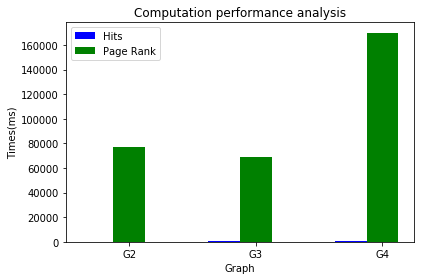

In [558]:
import matplotlib.pyplot as plt
# Computation performance analysis
def linkTest2(fn,itr):
    fmt = fn.split('.')[1]
    if fmt != 'csv':
        graph = Graph(fn)
    else:
        graph = TCGraph(fn)
        wk = {graph.wk[k]:k for k in graph.wk} 
#         print(wk)
        
    s_hits = datetime.datetime.now()
    hits = Hits(graph,iteration=itr, min_delta=0.0001)
    auth, hubs,_,_ = hits.do()    
    e_hits = datetime.datetime.now()
    Hits_time = (e_hits - s_hits).microseconds
    print("Do hits during time : {} ms".format(Hits_time))

    # page_rank
    # 6 graphs in project3dataset
    s_rank = datetime.datetime.now()
    page_rank = PageRank(graph, iteration=itr, damping_factor=0.85)
    ranks = page_rank.do()
    e_rank = datetime.datetime.now()    
    ranks_time = (e_rank - s_rank).microseconds
    print("Do page_rank during time : {} ms".format(ranks_time))  

    
    return Hits_time,ranks_time


import numpy as np
import matplotlib.pyplot as plt


itr = 40000
fn = 'hw3dataset/graph_{}.txt'.format(2)
h1,r1 = linkTest2(fn,itr=itr)
print('\n' +'---------------' + fn + 'Over'+'---------------'+ '\n')        

fn = 'hw3dataset/graph_{}.txt'.format(3)
h2,r2 =linkTest2(fn,itr=itr)
print('\n' +'---------------' + fn + 'Over'+'---------------'+ '\n')  

# fn = 'hw3dataset/BreadBasket_DMS.csv'
fn = 'hw3dataset/graph_{}.txt'.format(4)
h3,r3 = linkTest2(fn,itr=itr)
print('\n' +'---------------' + fn + 'Over'+'---------------'+ '\n')



# data to plot
n_groups = 3
time_g1 = (h1,h2,h3)
time_g2 = (r1,r2,r3)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1

rects1 = plt.bar(index, time_g1, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Hits')

rects2 = plt.bar(index + bar_width, time_g2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Page Rank')

plt.xlabel('Graph')
plt.ylabel('Times(ms)')
plt.title('Computation performance analysis')
plt.xticks(index + bar_width, ('G2', 'G3','G4'))
plt.legend()

plt.tight_layout()
plt.show()

# SimRank Performance from G1,G2,G3,G4

pair-wise similarity of nodes...
Do sim_rank during time : 8996 ms

---------------hw3dataset/graph_1.txtOver---------------

pair-wise similarity of nodes...
Do sim_rank during time : 9990 ms

---------------hw3dataset/graph_2.txtOver---------------

pair-wise similarity of nodes...
Do sim_rank during time : 7996 ms

---------------hw3dataset/graph_3.txtOver---------------

pair-wise similarity of nodes...
Do sim_rank during time : 56967 ms

---------------hw3dataset/graph_4.txtOver---------------



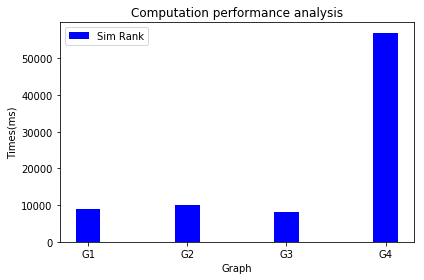

In [509]:
import matplotlib.pyplot as plt
# Computation performance analysis
def linkTest2(fn,itr):
    fmt = fn.split('.')[1]
    if fmt != 'csv':
        graph = Graph(fn)
    else:
        graph = TCGraph(fn)
        wk = {graph.wk[k]:k for k in graph.wk} 
#         print(wk)
        
# sim_rank
    # first 5 graphs of project3dataset.
    s_sim = datetime.datetime.now()
    simRank = SimRank(graph, C=0.9, iteration=itr)
    sim = simRank.do()   
    e_sim = datetime.datetime.now()    
    sim_time = (e_sim - s_sim).microseconds
    print("Do sim_rank during time : {} ms".format(sim_time))   
    
    return sim_time


import numpy as np
import matplotlib.pyplot as plt


data = []
for i in range(1,5):
    itr = 200
    fn = 'hw3dataset/graph_{}.txt'.format(i)
    s = linkTest2(fn,itr=itr)
    data.append(s)
    print('\n' +'---------------' + fn + 'Over'+'---------------'+ '\n')  

# data to plot
n_groups = 4
time_g1 = data

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1

rects1 = plt.bar(index, time_g1, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Sim Rank')



plt.xlabel('Graph')
plt.ylabel('Times(ms)')
plt.title('Computation performance analysis')
plt.xticks(index , ('G1', 'G2','G3','G4'))
plt.legend()

plt.tight_layout()
plt.show()